# Deep Learning - Assignment 2 - Problem 1
### Ali Abbasi - 98105879

# Importing Libraries

In [1]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import tqdm
import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

# Datasets and Dataloaders

In [2]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [3]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [4]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

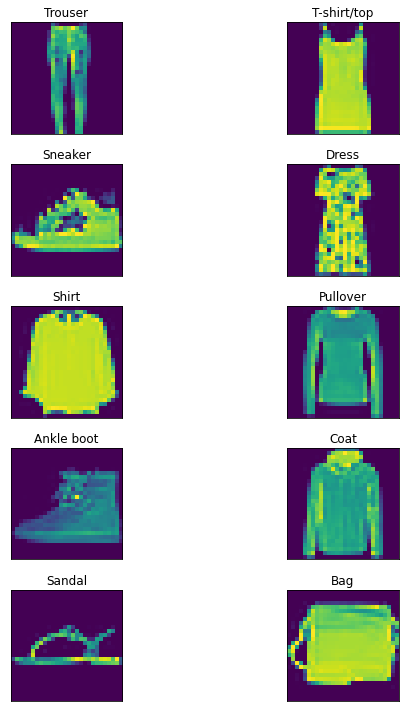

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.flat
seen_classes = []
topil = transforms.ToPILImage()
j = 0
while len(seen_classes) != len(train_set.classes):
    i = np.random.randint(0, len(train_set))
    x, y = train_set[i]
    if y in seen_classes:
        continue
    seen_classes.append(y)
    ax = axes[j]
    j += 1
    img = topil(x)
    ax.imshow(img)
    ax.set_title(train_set.classes[y])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Initializing model's parameters

In [6]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

In [7]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

# Defining needed functions

Computing affine and relu outputs:

In [8]:
def affine_forward(x, w, b):
    return x @ w + b


def relu(x):
    return torch.clamp(x, min=0)

Function `model` returns output of the whole model for the input `x`:

In [9]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    for i in range(num_layers - 1):
        x = affine_forward(x, parameters[f'w{i}'], parameters[f'b{i}'])
        x = relu(x)
    i = num_layers - 1
    x = affine_forward(x, parameters[f'w{i}'], parameters[f'b{i}'])
    return x

Implementing cross entropy loss:

In [10]:
def cross_entropy_loss(scores, y):
    n = len(y)
    # I have used logsumexp for numerical stability reasons
    logP = scores - torch.logsumexp(scores, dim=1, keepdim=True)
    return - torch.sum(logP[torch.arange(n), y]) / n

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [11]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    with torch.no_grad():
        for key in parameters.keys():
            parameters[key] -= learning_rate * parameters[key].grad
            # zero the gradients after loss.backward()
            parameters[key].grad.zero_()

Training functions:

In [12]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    return (y_true == y_pred).mean()


def train(train_loader, learning_rate=0.001, epoch=None):
    train_loss = 0
    N_train = len(train_loader.dataset)
    Y = []
    Y_pred = []
    with tqdm.tqdm(enumerate(train_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x, parameters)

            loss = cross_entropy_loss(p, y)
            
            train_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: Train Loss: {train_loss / N_train:.3e}')

            loss.backward()
            sgd_optimizer(parameters, learning_rate=learning_rate)

            y_pred = p.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    train_loss /= N_train

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []

    with torch.no_grad(), tqdm.tqdm(enumerate(loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x, parameters)
            y_pred = p.argmax(dim=-1)

            loss = cross_entropy_loss(p, y)

            total_loss += loss.item() * len(x)

            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [13]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [14]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, learning_rate, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_loss, test_acc = validate(test_loader, epoch, 'test')
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print('\n', '-' * 60)

    plt.plot(train_losses, label='train')
    plt.plot(test_losses, label='test')
    plt.title('loss history of training and test sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(test_accuracies, label='test')
    plt.title('Accuracy history of training and test sets')
    plt.legend()
    plt.show()

0: Train Loss: 2.287e+00: : 938it [00:19, 47.78it/s]


Accuracy of train set: 0.31776666666666664


0: test Loss: 2.261e+00: : 157it [00:01, 101.26it/s]


Accuracy of test set: 0.4116

 ------------------------------------------------------------


1: Train Loss: 2.017e+00: : 938it [00:10, 85.91it/s]


Accuracy of train set: 0.3794166666666667


1: test Loss: 1.463e+00: : 157it [00:01, 104.66it/s]


Accuracy of test set: 0.4386

 ------------------------------------------------------------


2: Train Loss: 1.158e+00: : 938it [00:15, 62.25it/s]


Accuracy of train set: 0.5282666666666667


2: test Loss: 1.014e+00: : 157it [00:01, 104.28it/s]


Accuracy of test set: 0.5884

 ------------------------------------------------------------


3: Train Loss: 8.959e-01: : 938it [00:10, 90.86it/s]


Accuracy of train set: 0.6568


3: test Loss: 8.525e-01: : 157it [00:01, 102.22it/s]


Accuracy of test set: 0.6623

 ------------------------------------------------------------


4: Train Loss: 7.873e-01: : 938it [00:10, 91.88it/s]


Accuracy of train set: 0.7134166666666667


4: test Loss: 8.860e-01: : 157it [00:01, 105.10it/s]


Accuracy of test set: 0.6888

 ------------------------------------------------------------


5: Train Loss: 7.169e-01: : 938it [00:11, 80.91it/s]


Accuracy of train set: 0.744


5: test Loss: 7.234e-01: : 157it [00:01, 102.07it/s]


Accuracy of test set: 0.7403

 ------------------------------------------------------------


6: Train Loss: 6.633e-01: : 938it [00:10, 89.68it/s]


Accuracy of train set: 0.7625333333333333


6: test Loss: 6.969e-01: : 157it [00:01, 102.86it/s]


Accuracy of test set: 0.7549

 ------------------------------------------------------------


7: Train Loss: 6.249e-01: : 938it [00:10, 89.39it/s]


Accuracy of train set: 0.7769166666666667


7: test Loss: 6.403e-01: : 157it [00:01, 80.30it/s]


Accuracy of test set: 0.7626

 ------------------------------------------------------------


8: Train Loss: 5.960e-01: : 938it [00:10, 91.33it/s]


Accuracy of train set: 0.78865


8: test Loss: 6.039e-01: : 157it [00:01, 100.77it/s]


Accuracy of test set: 0.7873

 ------------------------------------------------------------


9: Train Loss: 5.712e-01: : 938it [00:10, 85.50it/s]


Accuracy of train set: 0.7984833333333333


9: test Loss: 5.835e-01: : 157it [00:01, 103.83it/s]


Accuracy of test set: 0.7963

 ------------------------------------------------------------


10: Train Loss: 5.506e-01: : 938it [00:10, 91.11it/s]


Accuracy of train set: 0.8081


10: test Loss: 5.805e-01: : 157it [00:01, 102.84it/s]


Accuracy of test set: 0.7984

 ------------------------------------------------------------


11: Train Loss: 5.346e-01: : 938it [00:10, 89.47it/s]


Accuracy of train set: 0.8138833333333333


11: test Loss: 5.578e-01: : 157it [00:01, 103.66it/s]


Accuracy of test set: 0.8047

 ------------------------------------------------------------


12: Train Loss: 5.211e-01: : 938it [00:10, 91.46it/s]


Accuracy of train set: 0.8196


12: test Loss: 5.385e-01: : 157it [00:01, 104.60it/s]


Accuracy of test set: 0.8133

 ------------------------------------------------------------


13: Train Loss: 5.050e-01: : 938it [00:10, 88.49it/s]


Accuracy of train set: 0.8242833333333334


13: test Loss: 5.332e-01: : 157it [00:01, 81.80it/s]


Accuracy of test set: 0.8134

 ------------------------------------------------------------


14: Train Loss: 4.930e-01: : 938it [00:10, 90.21it/s]


Accuracy of train set: 0.8284333333333334


14: test Loss: 5.201e-01: : 157it [00:01, 102.56it/s]


Accuracy of test set: 0.8177

 ------------------------------------------------------------


15: Train Loss: 4.806e-01: : 938it [00:10, 90.82it/s]


Accuracy of train set: 0.83275


15: test Loss: 5.155e-01: : 157it [00:01, 104.54it/s]


Accuracy of test set: 0.8215

 ------------------------------------------------------------


16: Train Loss: 4.680e-01: : 938it [00:10, 90.41it/s]


Accuracy of train set: 0.8362333333333334


16: test Loss: 4.945e-01: : 157it [00:01, 102.44it/s]


Accuracy of test set: 0.8284

 ------------------------------------------------------------


17: Train Loss: 4.567e-01: : 938it [00:10, 89.91it/s]


Accuracy of train set: 0.8408166666666667


17: test Loss: 5.023e-01: : 157it [00:01, 101.02it/s]


Accuracy of test set: 0.8235

 ------------------------------------------------------------


18: Train Loss: 4.435e-01: : 938it [00:11, 84.57it/s]


Accuracy of train set: 0.84585


18: test Loss: 4.704e-01: : 157it [00:01, 100.09it/s]


Accuracy of test set: 0.8352

 ------------------------------------------------------------


19: Train Loss: 4.331e-01: : 938it [00:10, 89.76it/s]


Accuracy of train set: 0.8482333333333333


19: test Loss: 4.910e-01: : 157it [00:01, 102.05it/s]


Accuracy of test set: 0.8276

 ------------------------------------------------------------


20: Train Loss: 4.231e-01: : 938it [00:10, 88.93it/s]


Accuracy of train set: 0.8512666666666666


20: test Loss: 4.800e-01: : 157it [00:01, 102.13it/s]


Accuracy of test set: 0.8245

 ------------------------------------------------------------


21: Train Loss: 4.120e-01: : 938it [00:10, 88.67it/s]


Accuracy of train set: 0.85565


21: test Loss: 5.276e-01: : 157it [00:01, 101.90it/s]


Accuracy of test set: 0.8085

 ------------------------------------------------------------


22: Train Loss: 4.040e-01: : 938it [00:11, 84.85it/s]


Accuracy of train set: 0.8579166666666667


22: test Loss: 4.619e-01: : 157it [00:01, 102.44it/s]


Accuracy of test set: 0.8337

 ------------------------------------------------------------


23: Train Loss: 3.943e-01: : 938it [00:10, 90.21it/s]


Accuracy of train set: 0.8614833333333334


23: test Loss: 4.417e-01: : 157it [00:02, 57.52it/s]


Accuracy of test set: 0.8411

 ------------------------------------------------------------


24: Train Loss: 3.863e-01: : 938it [00:11, 85.22it/s]


Accuracy of train set: 0.8635666666666667


24: test Loss: 4.452e-01: : 157it [00:01, 100.65it/s]


Accuracy of test set: 0.8431

 ------------------------------------------------------------


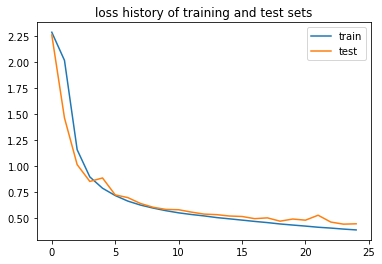

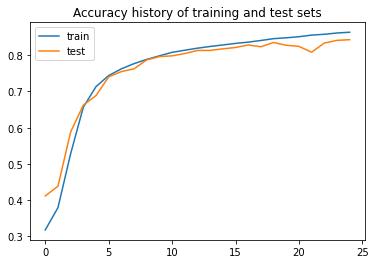

In [15]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [16]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8431


We've reached the required accuracy on test set.

## Visualizing Results

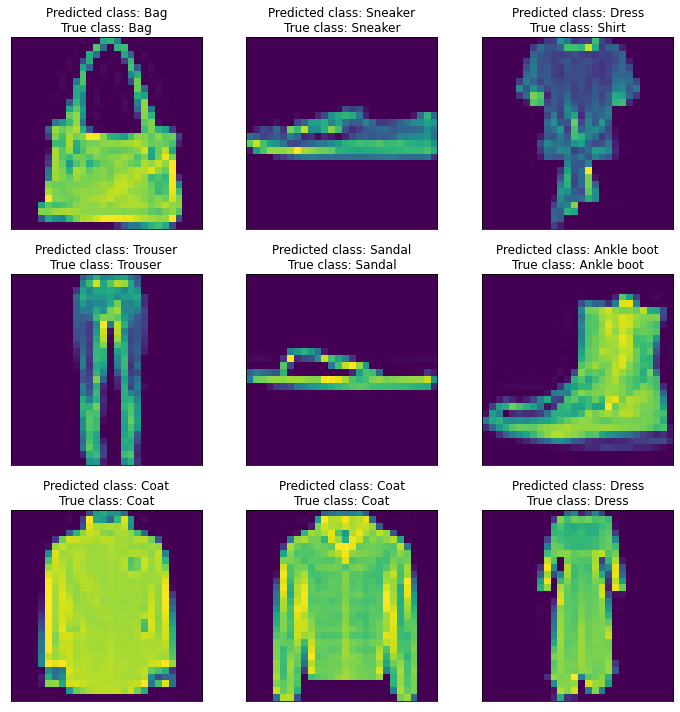

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flat
for ax in axes:
    i = np.random.randint(0, len(train_set))
    x, y = train_set[i]
    x_device = x.clone().detach()
    x_device = x_device.to(device)
    p = model(x_device, parameters)
    y_pred = p.argmax(dim=-1).cpu().numpy()[0]
    ax.imshow(topil(x))
    ax.set_title(f'Predicted class: {train_set.classes[y_pred]}\nTrue class: {train_set.classes[y]}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()